This notebook is used for using [cell2location](https://doi.org/10.1038/s41587-021-01139-4) tool to integrate scRNAseq data with ST data.It follows the tutorial given for the tool on [this page](https://cell2location.readthedocs.io/en/latest/notebooks/cell2location_tutorial.html),as well as some additional QC steps.

This script uses 9 major cell types with percentage threshold idea for spot annotation.


## Initialisation of packages and paths

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import squidpy as sq
from scipy.sparse import csr_matrix
import anndata as ad
import os

import cell2location
from cell2location.utils.filtering import filter_genes
from cell2location.models import RegressionModel
from cell2location import run_colocation
from cell2location.utils import select_slide

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

/disk2/user/hilpek/miniconda3/envs/cell2_env/lib/python3.9/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/disk2/user/hilpek/miniconda3/envs/cell2_env/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/disk2/user/hilpek/miniconda3/envs/cell2_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
results_folder = '/disk2/user/hilpek/project_root/cell2location/outputs/cell2loc2_1'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

## Reading the Visium Data

In [3]:
adata_vis = sq.read.visium("/disk3/cda/SpatialTranscriptomics/processed-data/SpaceRanger-output_v1.0.0-rerun2023/V10F03-034_C/outs",
        counts_file='filtered_feature_bc_matrix.h5', 
        source_image_path="/disk3/cda/SpatialTranscriptomics/raw-data/High-resolution_tissue_images/V10F03-034/210223_BC_S7_V10F03-034_RJ.C1-Spot000001.jpg"
    )

/disk2/user/hilpek/miniconda3/envs/cell2_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/disk2/user/hilpek/miniconda3/envs/cell2_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
adata_vis

AnnData object with n_obs × n_vars = 2061 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
adata_vis.uns

OrderedDict([('spatial',
              {'V10F03-034_C': {'metadata': {'chemistry_description': "Spatial 3' v1",
                 'software_version': 'spaceranger-1.0.0',
                 'source_image_path': '/disk3/cda/SpatialTranscriptomics/raw-data/High-resolution_tissue_images/V10F03-034/210223_BC_S7_V10F03-034_RJ.C1-Spot000001.jpg'},
                'images': {'hires': array([[[255, 255, 255],
                         [255, 255, 255],
                         [255, 255, 255],
                         ...,
                         [255, 255, 255],
                         [255, 255, 255],
                         [255, 255, 255]],
                 
                        [[255, 255, 255],
                         [255, 255, 255],
                         [255, 255, 255],
                         ...,
                         [255, 255, 255],
                         [255, 255, 255],
                         [255, 255, 255]],
                 
                        [[255, 255, 25

In [6]:
adata_vis.obsm

AxisArrays with keys: spatial

### Prepare adata_vis.obs

In [7]:
# get the sample id for each spot
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

In [8]:
# add pathologist annotations
annoDf = pd.read_csv("/disk3/cda/SpatialTranscriptomics/pathologist_annotations/Tissue-annotations_pathologist-2-and-3_CSVs/V10F03-034_C_S7_Wenwen-annotations.csv")

# replace empty annotations with "Mixed"
annoDf.fillna('Mixed', inplace=True)
annoArray = annoDf["Wenwen annotations"].to_numpy()
adata_vis.obs["Pathologist_annotations"] = pd.Categorical(annoArray)

In [9]:
# add sample name to obs names, important for looking at individual slides later
adata_vis.obs["sample"] = [str(i) for i in adata_vis.obs['sample']]
adata_vis.obs_names = adata_vis.obs["sample"] + '_' + adata_vis.obs_names
adata_vis.obs.index.name = 'spot_id'

adata_vis.obs

in_tissue  array_row  array_col  \
spot_id                                                            
V10F03-034_C_AAACACCAATAACTGC-1          1         59         19   
V10F03-034_C_AAACAGCTTTCAGAAG-1          1         43          9   
V10F03-034_C_AAACAGGGTCTATATT-1          1         47         13   
V10F03-034_C_AAACAGTGTTCCTGGG-1          1         73         43   
V10F03-034_C_AAACATGGTGAGAGGA-1          1         62          0   
...                                    ...        ...        ...   
V10F03-034_C_TTGTTGTGTGTCAAGA-1          1         31         77   
V10F03-034_C_TTGTTTCACATCCAGG-1          1         58         42   
V10F03-034_C_TTGTTTCATTAGTCTA-1          1         60         30   
V10F03-034_C_TTGTTTCCATACAACT-1          1         45         27   
V10F03-034_C_TTGTTTGTATTACACG-1          1         73         41   

                                       sample Pathologist_annotations  
spot_id                                                                
V10F03-034_C_AAACACCAATAACTGC-1  V10F03-034_C                   Tumor  
V10F03-034_C_AAACAGCTTTCAGAAG-1  V10F03-034_C                   Tumor  
V10F03-034_C_AAACAGGGTCTATATT-1  V10F03-034_C                   Mixed  
V10F03-034_C_AAACAGTGTTCCTGGG-1  V10F03-034_C                   Tumor  
V10F03-034_C_AAACATGGTGAGAGGA-1  V10F03-034_C                   Tumor  
...                                       ...                     ...  
V10F03-034_C_TTGTTGTGTGTCAAGA-1  V10F03-034_C                   Tumor  
V10F03-034_C_TTGTTTCACATCCAGG-1  V10F03-034_C                   Tumor  
V10F03-034_C_TTGTTTCATTAGTCTA-1  V10F03-034_C                   Mixed  
V10F03-034_C_TTGTTTCCATACAACT-1  V10F03-034_C                   Tumor  
V10F03-034_C_TTGTTTGTATTACACG-1  V10F03-034_C                   Tumor  

[2061 rows x 5 columns]

In [10]:
adata_vis.obs["Pathologist_annotations"].value_counts()

Pathologist_annotations
Tumor            1209
Mixed             565
Stroma            213
Immune cells       57
Benign breast      17
Name: count, dtype: int64

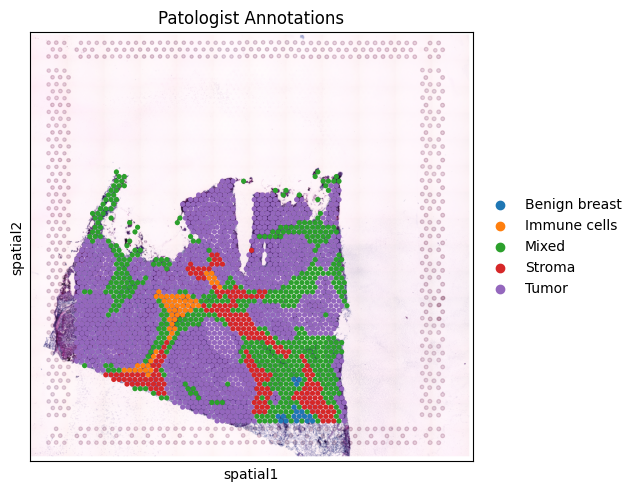

In [11]:
sq.pl.spatial_scatter(
    adata_vis,
    color="Pathologist_annotations",
    title="Patologist Annotations",
    size=1.5
)

### Prepare adata_vis.var

In [12]:
# rename genes to Ensembl IDs
adata_vis.var['SYMBOL'] = adata_vis.var_names
adata_vis.var.set_index('gene_ids', drop=True, inplace=True)
adata_vis.var

feature_types  genome       SYMBOL
gene_ids                                             
ENSG00000243485  Gene Expression  GRCh38  MIR1302-2HG
ENSG00000237613  Gene Expression  GRCh38      FAM138A
ENSG00000186092  Gene Expression  GRCh38        OR4F5
ENSG00000238009  Gene Expression  GRCh38   AL627309.1
ENSG00000239945  Gene Expression  GRCh38   AL627309.3
...                          ...     ...          ...
ENSG00000277836  Gene Expression  GRCh38   AC141272.1
ENSG00000278633  Gene Expression  GRCh38   AC023491.2
ENSG00000276017  Gene Expression  GRCh38   AC007325.1
ENSG00000278817  Gene Expression  GRCh38   AC007325.4
ENSG00000277196  Gene Expression  GRCh38   AC007325.2

[36601 rows x 3 columns]

In [13]:
# calculate QC metrics
if not isinstance(adata_vis.X, np.ndarray):
    adata_vis.X = adata_vis.X.toarray()
    
adata_vis.var['mt'] = adata_vis.var["SYMBOL"].str.startswith(("mt-", "MT-"))
adata_vis.var["ribo"] = adata_vis.var["SYMBOL"].str.startswith(("RPS", "RPL"))

sc.pp.calculate_qc_metrics(adata_vis, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

adata_vis.X = csr_matrix(adata_vis.X)
adata_vis.X

<2061x36601 sparse matrix of type '<class 'numpy.float32'>'
	with 1532651 stored elements in Compressed Sparse Row format>

In [14]:
adata_vis.obs

in_tissue  array_row  array_col  \
spot_id                                                            
V10F03-034_C_AAACACCAATAACTGC-1          1         59         19   
V10F03-034_C_AAACAGCTTTCAGAAG-1          1         43          9   
V10F03-034_C_AAACAGGGTCTATATT-1          1         47         13   
V10F03-034_C_AAACAGTGTTCCTGGG-1          1         73         43   
V10F03-034_C_AAACATGGTGAGAGGA-1          1         62          0   
...                                    ...        ...        ...   
V10F03-034_C_TTGTTGTGTGTCAAGA-1          1         31         77   
V10F03-034_C_TTGTTTCACATCCAGG-1          1         58         42   
V10F03-034_C_TTGTTTCATTAGTCTA-1          1         60         30   
V10F03-034_C_TTGTTTCCATACAACT-1          1         45         27   
V10F03-034_C_TTGTTTGTATTACACG-1          1         73         41   

                                       sample Pathologist_annotations  \
spot_id                                                                 
V10F03-034_C_AAACACCAATAACTGC-1  V10F03-034_C                   Tumor   
V10F03-034_C_AAACAGCTTTCAGAAG-1  V10F03-034_C                   Tumor   
V10F03-034_C_AAACAGGGTCTATATT-1  V10F03-034_C                   Mixed   
V10F03-034_C_AAACAGTGTTCCTGGG-1  V10F03-034_C                   Tumor   
V10F03-034_C_AAACATGGTGAGAGGA-1  V10F03-034_C                   Tumor   
...                                       ...                     ...   
V10F03-034_C_TTGTTGTGTGTCAAGA-1  V10F03-034_C                   Tumor   
V10F03-034_C_TTGTTTCACATCCAGG-1  V10F03-034_C                   Tumor   
V10F03-034_C_TTGTTTCATTAGTCTA-1  V10F03-034_C                   Mixed   
V10F03-034_C_TTGTTTCCATACAACT-1  V10F03-034_C                   Tumor   
V10F03-034_C_TTGTTTGTATTACACG-1  V10F03-034_C                   Tumor   

                                 n_genes_by_counts  total_counts  \
spot_id                                                            
V10F03-034_C_AAACACCAATAACTGC-1                447         562.0   
V10F03-034_C_AAACAGCTTTCAGAAG-1                711         980.0   
V10F03-034_C_AAACAGGGTCTATATT-1                754         939.0   
V10F03-034_C_AAACAGTGTTCCTGGG-1                306         352.0   
V10F03-034_C_AAACATGGTGAGAGGA-1               1229        1770.0   
...                                            ...           ...   
V10F03-034_C_TTGTTGTGTGTCAAGA-1                338         383.0   
V10F03-034_C_TTGTTTCACATCCAGG-1                351         417.0   
V10F03-034_C_TTGTTTCATTAGTCTA-1               1208        2311.0   
V10F03-034_C_TTGTTTCCATACAACT-1                294         372.0   
V10F03-034_C_TTGTTTGTATTACACG-1                402         489.0   

                                 total_counts_mt  pct_counts_mt  \
spot_id                                                           
V10F03-034_C_AAACACCAATAACTGC-1             11.0       1.957295   
V10F03-034_C_AAACAGCTTTCAGAAG-1             22.0       2.244898   
V10F03-034_C_AAACAGGGTCTATATT-1             18.0       1.916933   
V10F03-034_C_AAACAGTGTTCCTGGG-1             17.0       4.829545   
V10F03-034_C_AAACATGGTGAGAGGA-1             19.0       1.073446   
...                                          ...            ...   
V10F03-034_C_TTGTTGTGTGTCAAGA-1             12.0       3.133159   
V10F03-034_C_TTGTTTCACATCCAGG-1             24.0       5.755396   
V10F03-034_C_TTGTTTCATTAGTCTA-1             34.0       1.471225   
V10F03-034_C_TTGTTTCCATACAACT-1             12.0       3.225806   
V10F03-034_C_TTGTTTGTATTACACG-1             20.0       4.089980   

                                 total_counts_ribo  pct_counts_ribo  
spot_id                                                              
V10F03-034_C_AAACACCAATAACTGC-1               56.0         9.964413  
V10F03-034_C_AAACAGCTTTCAGAAG-1              140.0        14.285715  
V10F03-034_C_AAACAGGGTCTATATT-1               92.0         9.797657  
V10F03-034_C_AAACAGTGTTCCTGGG-1               34.0         9.659091  
V10F03-034_C_AAACATGG

In [15]:
# check the presence of mitochondrial genes
adata_vis.var[adata_vis.var["mt"]==True]

feature_types  genome   SYMBOL    mt   ribo  \
gene_ids                                                         
ENSG00000198888  Gene Expression  GRCh38   MT-ND1  True  False   
ENSG00000198763  Gene Expression  GRCh38   MT-ND2  True  False   
ENSG00000198804  Gene Expression  GRCh38   MT-CO1  True  False   
ENSG00000198712  Gene Expression  GRCh38   MT-CO2  True  False   
ENSG00000228253  Gene Expression  GRCh38  MT-ATP8  True  False   
ENSG00000198899  Gene Expression  GRCh38  MT-ATP6  True  False   
ENSG00000198938  Gene Expression  GRCh38   MT-CO3  True  False   
ENSG00000198840  Gene Expression  GRCh38   MT-ND3  True  False   
ENSG00000212907  Gene Expression  GRCh38  MT-ND4L  True  False   
ENSG00000198886  Gene Expression  GRCh38   MT-ND4  True  False   
ENSG00000198786  Gene Expression  GRCh38   MT-ND5  True  False   
ENSG00000198695  Gene Expression  GRCh38   MT-ND6  True  False   
ENSG00000198727  Gene Expression  GRCh38   MT-CYB  True  False   

                 n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
gene_ids                                                                 
ENSG00000198888               1643     2.918971              20.281417   
ENSG00000198763               1083     1.051431              47.452693   
ENSG00000198804               1859     5.473071               9.801067   
ENSG00000198712               1804     4.626395              12.469675   
ENSG00000228253                 75     0.037361              96.360990   
ENSG00000198899               1618     2.763707              21.494420   
ENSG00000198938               1955     7.518680               5.143134   
ENSG00000198840               1515     2.495391              26.491994   
ENSG00000212907                136     0.076177              93.401262   
ENSG00000198886               1787     4.219311              13.294517   
ENSG00000198786                334     0.211063              83.794275   
ENSG00000198695                 12     0.005822              99.417758   
ENSG00000198727               1487     2.098496              27.850558   

                 total_counts  
gene_ids                       
ENSG00000198888        6016.0  
ENSG00000198763        2167.0  
ENSG00000198804       11280.0  
ENSG00000198712        9535.0  
ENSG00000228253          77.0  
ENSG00000198899        5696.0  
ENSG00000198938       15496.0  
ENSG00000198840        5143.0  
ENSG00000212907         157.0  
ENSG00000198886        8696.0  
ENSG00000198786         435.0  
ENSG00000198695          12.0  
ENSG00000198727        4325.0

In [16]:
# check the presence of ribosomal genes
adata_vis.var[adata_vis.var["ribo"]==True]

feature_types  genome   SYMBOL     mt  ribo  \
gene_ids                                                         
ENSG00000116251  Gene Expression  GRCh38    RPL22  False  True   
ENSG00000142676  Gene Expression  GRCh38    RPL11  False  True   
ENSG00000117676  Gene Expression  GRCh38  RPS6KA1  False  True   
ENSG00000142937  Gene Expression  GRCh38     RPS8  False  True   
ENSG00000122406  Gene Expression  GRCh38     RPL5  False  True   
...                          ...     ...      ...    ...   ...   
ENSG00000241343  Gene Expression  GRCh38   RPL36A  False  True   
ENSG00000198918  Gene Expression  GRCh38    RPL39  False  True   
ENSG00000147403  Gene Expression  GRCh38    RPL10  False  True   
ENSG00000129824  Gene Expression  GRCh38   RPS4Y1  False  True   
ENSG00000280969  Gene Expression  GRCh38   RPS4Y2  False  True   

                 n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
gene_ids                                                                 
ENSG00000116251               1253     1.379913              39.204270   
ENSG00000142676               1554     2.149927              24.599709   
ENSG00000117676                103     0.051431              95.002426   
ENSG00000142937               1608     2.542455              21.979622   
ENSG00000122406               1313     1.384765              36.293062   
...                            ...          ...                    ...   
ENSG00000241343               1294     1.542940              37.214944   
ENSG00000198918               1376     1.702572              33.236293   
ENSG00000147403               1519     2.293062              26.297914   
ENSG00000129824                  1     0.000485              99.951480   
ENSG00000280969                  0     0.000000             100.000000   

                 total_counts  
gene_ids                       
ENSG00000116251        2844.0  
ENSG00000142676        4431.0  
ENSG00000117676         106.0  
ENSG00000142937        5240.0  
ENSG00000122406        2854.0  
...                       ...  
ENSG00000241343        3180.0  
ENSG00000198918        3509.0  
ENSG00000147403        4726.0  
ENSG00000129824           1.0  
ENSG00000280969           0.0  

[103 rows x 9 columns]

###  Filter mitochondrial and ribosomal genes

In [17]:
# find and remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obs['mt_frac'] = adata_vis[:, adata_vis.var['mt'].tolist()].X.sum(1).A.squeeze()/adata_vis.obs['total_counts']
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['mt'].values].X.toarray()


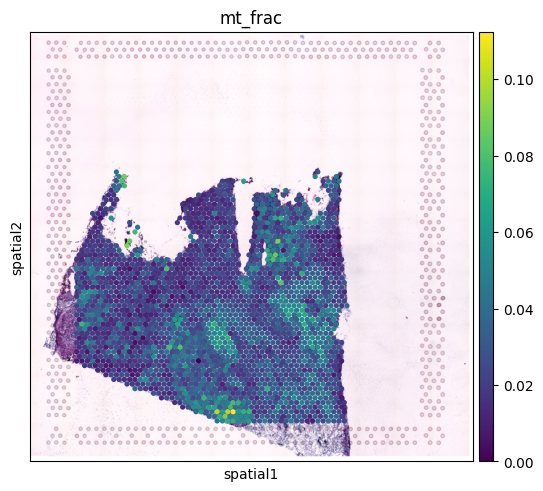

In [18]:
sq.pl.spatial_scatter(adata_vis, color='mt_frac', cmap='viridis', size=1.5)

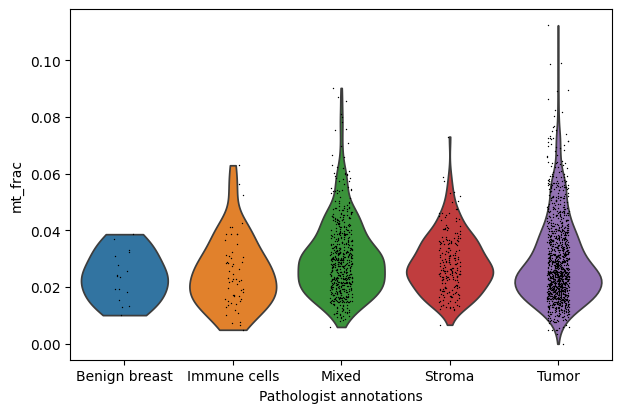

In [19]:
sc.pl.violin(adata_vis, keys='mt_frac', groupby='Pathologist_annotations')

In [20]:
adata_vis = adata_vis[:, ~adata_vis.var['mt'].values]
adata_vis

View of AnnData object with n_obs × n_vars = 2061 × 36588
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'Pathologist_annotations', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'mt_frac'
    var: 'feature_types', 'genome', 'SYMBOL', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'spatial', 'Pathologist_annotations_colors'
    obsm: 'spatial', 'MT'

In [21]:
# find and remove RB genes for spatial mapping (keeping their counts in the objm)
adata_vis.obs['ribo_frac'] = adata_vis[:, adata_vis.var['ribo'].tolist()].X.sum(1).A.squeeze()/adata_vis.obs['total_counts']
adata_vis.obsm['RB'] = adata_vis[:, adata_vis.var['ribo'].values].X.toarray()


/tmp/ipykernel_310939/1201221376.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_vis.obs['ribo_frac'] = adata_vis[:, adata_vis.var['ribo'].tolist()].X.sum(1).A.squeeze()/adata_vis.obs['total_counts']


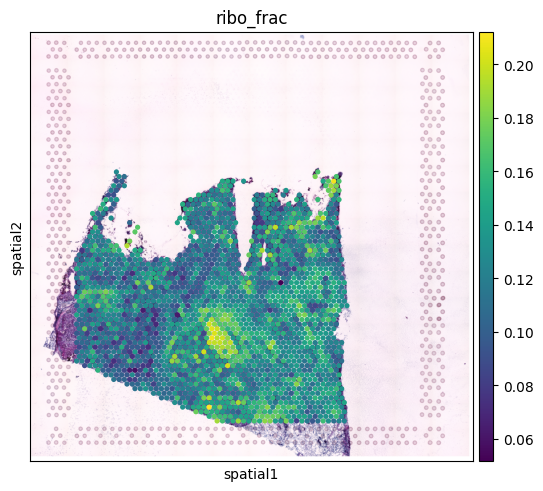

In [22]:
sq.pl.spatial_scatter(adata_vis, color='ribo_frac', cmap='viridis', size=1.5)

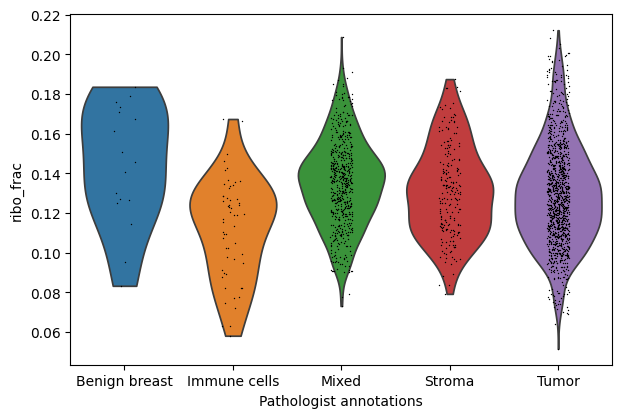

In [23]:
sc.pl.violin(adata_vis, keys='ribo_frac', groupby='Pathologist_annotations')

In [24]:
adata_vis = adata_vis[:, ~adata_vis.var['ribo'].values]
adata_vis

View of AnnData object with n_obs × n_vars = 2061 × 36485
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'Pathologist_annotations', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'mt_frac', 'ribo_frac'
    var: 'feature_types', 'genome', 'SYMBOL', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'spatial', 'Pathologist_annotations_colors'
    obsm: 'spatial', 'MT', 'RB'

### Determine QC thresholds

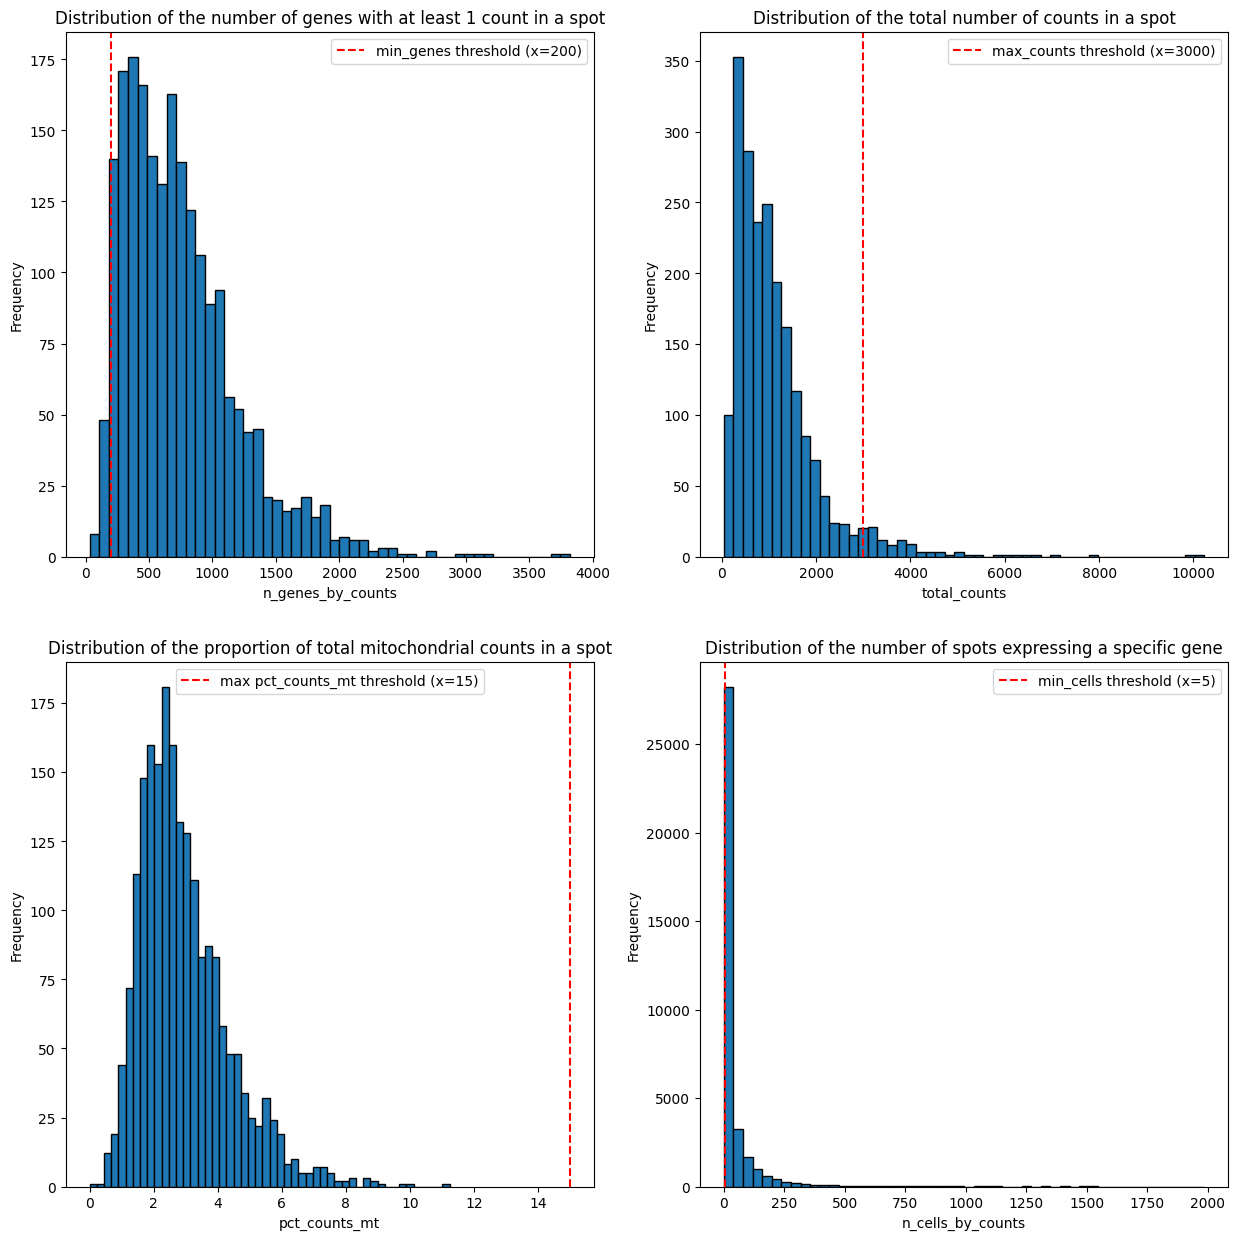

In [25]:
# create 4 subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

# plot n_genes_by_counts for min_genes threshold
axes[0][0].hist(adata_vis.obs['n_genes_by_counts'], bins=50, edgecolor="black")
axes[0][0].set_title('Distribution of the number of genes with at least 1 count in a spot')
axes[0][0].axvline(x=200, color='red', linestyle='--', linewidth=1.5, label='min_genes threshold (x=200)')
axes[0][0].legend()
axes[0][0].set_xlabel('n_genes_by_counts')
axes[0][0].set_ylabel('Frequency')

# plot total_counts for max_counts threshold
axes[0][1].hist(adata_vis.obs['total_counts'], bins=50, edgecolor="black")
axes[0][1].set_title('Distribution of the total number of counts in a spot')
axes[0][1].axvline(x=3000, color='red', linestyle='--', linewidth=1.5, label='max_counts threshold (x=3000)')
axes[0][1].legend()
axes[0][1].set_xlabel('total_counts')
axes[0][1].set_ylabel('Frequency')

# plot pct_counts_mt for pct_counts_mt threshold
axes[1][0].hist(adata_vis.obs['pct_counts_mt'], bins=50, edgecolor="black")
axes[1][0].set_title('Distribution of the proportion of total mitochondrial counts in a spot')
axes[1][0].axvline(x=15, color='red', linestyle='--', linewidth=1.5, label='max pct_counts_mt threshold (x=15)')
axes[1][0].legend()
axes[1][0].set_xlabel('pct_counts_mt')
axes[1][0].set_ylabel('Frequency')

# plot n_cells_by_counts for min_cells threshold
axes[1][1].hist(adata_vis.var['n_cells_by_counts'], bins=50, edgecolor="black")
axes[1][1].set_title('Distribution of the number of spots expressing a specific gene')
axes[1][1].axvline(x=5, color='red', linestyle='--', linewidth=1.5, label='min_cells threshold (x=5)')
axes[1][1].legend()
axes[1][1].set_xlabel('n_cells_by_counts')
axes[1][1].set_ylabel('Frequency')

plt.show()

In [26]:
# choose appropriate thresholds for ST data
sc.pp.filter_cells(adata_vis, min_genes = 200)
sc.pp.filter_cells(adata_vis, max_counts= 3000)
adata_vis = adata_vis[adata_vis.obs["pct_counts_mt"] < 5]

# filter genes that are only present in a few spots
sc.pp.filter_genes(adata_vis, min_cells=5)
adata_vis

/disk2/user/hilpek/miniconda3/envs/cell2_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/disk2/user/hilpek/miniconda3/envs/cell2_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:283: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


AnnData object with n_obs × n_vars = 1762 × 14138
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'Pathologist_annotations', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'mt_frac', 'ribo_frac', 'n_genes', 'n_counts'
    var: 'feature_types', 'genome', 'SYMBOL', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'spatial', 'Pathologist_annotations_colors'
    obsm: 'spatial', 'MT', 'RB'

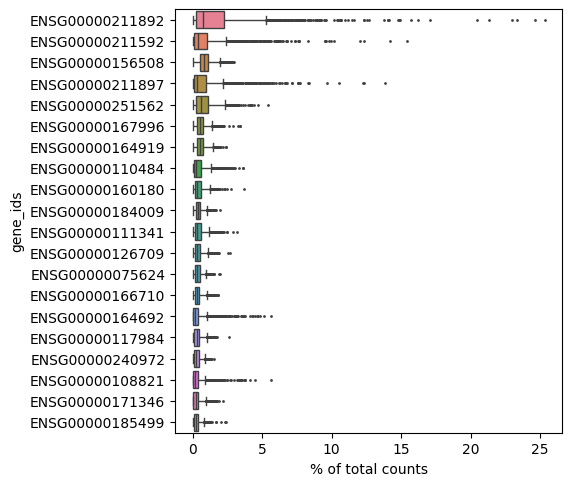

In [27]:
sc.pl.highest_expr_genes(adata_vis, n_top=20, )  # Highest expression genes overall look

### Final structure

In [28]:
adata_vis.var

feature_types  genome      SYMBOL     mt   ribo  \
gene_ids                                                             
ENSG00000241860  Gene Expression  GRCh38  AL627309.5  False  False   
ENSG00000237491  Gene Expression  GRCh38   LINC01409  False  False   
ENSG00000228794  Gene Expression  GRCh38   LINC01128  False  False   
ENSG00000223764  Gene Expression  GRCh38   LINC02593  False  False   
ENSG00000187634  Gene Expression  GRCh38      SAMD11  False  False   
...                          ...     ...         ...    ...    ...   
ENSG00000185973  Gene Expression  GRCh38       TMLHE  False  False   
ENSG00000124333  Gene Expression  GRCh38       VAMP7  False  False   
ENSG00000277400  Gene Expression  GRCh38  AC145212.1  False  False   
ENSG00000278817  Gene Expression  GRCh38  AC007325.4  False  False   
ENSG00000277196  Gene Expression  GRCh38  AC007325.2  False  False   

                 n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
gene_ids                                                                 
ENSG00000241860                  8     0.003882              99.611839   
ENSG00000237491                 25     0.012130              98.786997   
ENSG00000228794                 46     0.022804              97.768074   
ENSG00000223764                 17     0.008248              99.175158   
ENSG00000187634                 21     0.010674              98.981077   
...                            ...          ...                    ...   
ENSG00000185973                 20     0.009704              99.029597   
ENSG00000124333                 31     0.015526              98.495876   
ENSG00000277400                 51     0.024745              97.525473   
ENSG00000278817                 90     0.049976              95.633188   
ENSG00000277196                 21     0.010189              98.981077   

                 total_counts  n_cells  
gene_ids                                
ENSG00000241860           8.0        8  
ENSG00000237491          25.0       24  
ENSG00000228794          47.0       40  
ENSG00000223764          17.0       15  
ENSG00000187634          22.0       16  
...                       ...      ...  
ENSG00000185973          20.0       17  
ENSG00000124333          32.0       29  
ENSG00000277400          51.0       44  
ENSG00000278817         103.0       78  
ENSG00000277196          21.0       18  

[14138 rows x 10 columns]

In [29]:
adata_vis.obs

in_tissue  array_row  array_col  \
spot_id                                                            
V10F03-034_C_AAACACCAATAACTGC-1          1         59         19   
V10F03-034_C_AAACAGCTTTCAGAAG-1          1         43          9   
V10F03-034_C_AAACAGGGTCTATATT-1          1         47         13   
V10F03-034_C_AAACAGTGTTCCTGGG-1          1         73         43   
V10F03-034_C_AAACATGGTGAGAGGA-1          1         62          0   
...                                    ...        ...        ...   
V10F03-034_C_TTGTGTTTCCCGAAAG-1          1         51         59   
V10F03-034_C_TTGTTGTGTGTCAAGA-1          1         31         77   
V10F03-034_C_TTGTTTCATTAGTCTA-1          1         60         30   
V10F03-034_C_TTGTTTCCATACAACT-1          1         45         27   
V10F03-034_C_TTGTTTGTATTACACG-1          1         73         41   

                                       sample Pathologist_annotations  \
spot_id                                                                 
V10F03-034_C_AAACACCAATAACTGC-1  V10F03-034_C                   Tumor   
V10F03-034_C_AAACAGCTTTCAGAAG-1  V10F03-034_C                   Tumor   
V10F03-034_C_AAACAGGGTCTATATT-1  V10F03-034_C                   Mixed   
V10F03-034_C_AAACAGTGTTCCTGGG-1  V10F03-034_C                   Tumor   
V10F03-034_C_AAACATGGTGAGAGGA-1  V10F03-034_C                   Tumor   
...                                       ...                     ...   
V10F03-034_C_TTGTGTTTCCCGAAAG-1  V10F03-034_C                  Stroma   
V10F03-034_C_TTGTTGTGTGTCAAGA-1  V10F03-034_C                   Tumor   
V10F03-034_C_TTGTTTCATTAGTCTA-1  V10F03-034_C                   Mixed   
V10F03-034_C_TTGTTTCCATACAACT-1  V10F03-034_C                   Tumor   
V10F03-034_C_TTGTTTGTATTACACG-1  V10F03-034_C                   Tumor   

                                 n_genes_by_counts  total_counts  \
spot_id                                                            
V10F03-034_C_AAACACCAATAACTGC-1                447         562.0   
V10F03-034_C_AAACAGCTTTCAGAAG-1                711         980.0   
V10F03-034_C_AAACAGGGTCTATATT-1                754         939.0   
V10F03-034_C_AAACAGTGTTCCTGGG-1                306         352.0   
V10F03-034_C_AAACATGGTGAGAGGA-1               1229        1770.0   
...                                            ...           ...   
V10F03-034_C_TTGTGTTTCCCGAAAG-1                721        1269.0   
V10F03-034_C_TTGTTGTGTGTCAAGA-1                338         383.0   
V10F03-034_C_TTGTTTCATTAGTCTA-1               1208        2311.0   
V10F03-034_C_TTGTTTCCATACAACT-1                294         372.0   
V10F03-034_C_TTGTTTGTATTACACG-1                402         489.0   

                                 total_counts_mt  pct_counts_mt  \
spot_id                                                           
V10F03-034_C_AAACACCAATAACTGC-1             11.0       1.957295   
V10F03-034_C_AAACAGCTTTCAGAAG-1             22.0       2.244898   
V10F03-034_C_AAACAGGGTCTATATT-1             18.0       1.916933   
V10F03-034_C_AAACAGTGTTCCTGGG-1             17.0       4.829545   
V10F03-034_C_AAACATGGTGAGAGGA-1             19.0       1.073446   
...                                          ...            ...   
V10F03-034_C_TTGTGTTTCCCGAAAG-1             35.0       2.758077   
V10F03-034_C_TTGTTGTGTGTCAAGA-1             12.0       3.133159   
V10F03-034_C_TTGTTTCATTAGTCTA-1             34.0       1.471225   
V10F03-034_C_TTGTTTCCATACAACT-1             12.0       3.225806   
V10F03-034_C_TTGTTTGTATTACACG-1             20.0       4.089980   

                                 total_counts_ribo  pct_counts_ribo   mt_frac  \
spot_id                                                                         
V10F03-034_C_AAACACCAATAACTGC-1               56.0         9.964413  0.019573   
V10F03-034_C_AAACAGCTTTCAGAAG-1              140.0        14.285715  0.022449   
V10F03-034_C_AAACAGGGTCTATATT-1               92.0         9.797657  0.019169   
V10F03-034_C_AAACAGTGTTCCTGGG-1     

## Reading scRNAseq Data

In [30]:
adata_ref = ad.read_h5ad('/disk2/user/hilpek/project_root/scRNAseq/input/Wu_all_NT.h5ad')
# Removed HER samples.
adata_ref = adata_ref[(adata_ref.obs['IHC_subtype'] == 'ER+'), :]
# mt and ribo columns have been added to adata.var
adata_ref.var['mt'] = adata_ref.var_names.str.upper().str.startswith('MT-')
adata_ref.var['ribo'] = adata_ref.var_names.str.upper().str.startswith(('RPL', 'RPS'))
adata_ref.var_names_make_unique()
adata_ref

/tmp/ipykernel_310939/834681103.py:5: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_ref.var['mt'] = adata_ref.var_names.str.upper().str.startswith('MT-')


AnnData object with n_obs × n_vars = 33790 × 29733
    obs: 'Study_id', 'Celltype_subset', 'bc_subtype', 'donor_age', 'treatment_status', 'grade', 'IHC_subtype', 'Dataset'
    var: 'ENSEMBL', 'mt', 'ribo'

### Get major cell types

In [31]:
# load metadata
metadata = pd.read_csv("/disk2/user/hilpek/project_root/scRNAseq/input/metadata.csv", sep=",")
metadata.set_index('Unnamed: 0', inplace=True)
metadata

orig.ident  nCount_RNA  nFeature_RNA  percent.mito  \
Unnamed: 0                                                                    
CID3586_AAGACCTCAGCATGAG    CID3586        4581          1689      1.506221   
CID3586_AAGGTTCGTAGTACCT    CID3586        1726           779      5.793743   
CID3586_ACCAGTAGTTGTGGCC    CID3586        1229           514      1.383238   
CID3586_ACCCACTAGATGTCGG    CID3586        1352           609      1.923077   
CID3586_ACTGATGGTCAACTGT    CID3586        1711           807     13.325541   
...                             ...         ...           ...           ...   
CID4398_TCAGGTAGTACTCAAC    CID4398        6189          1251      2.698336   
CID4398_TCTATTGTCGCCATAA    CID4398        4611           719      3.057905   
CID4398_TCTTTCCCAGTAAGCG    CID4398        2987           887      3.682625   
CID4398_TGCCCATGTTACGGAG    CID4398        5117           870      2.208325   
CID4398_TTGAACGTCCTATTCA    CID4398        6679          1231      2.126067   

                         subtype      celltype_subset     celltype_minor  \
Unnamed: 0                                                                 
CID3586_AAGACCTCAGCATGAG   HER2+    Endothelial ACKR1  Endothelial ACKR1   
CID3586_AAGGTTCGTAGTACCT   HER2+    Endothelial ACKR1  Endothelial ACKR1   
CID3586_ACCAGTAGTTGTGGCC   HER2+    Endothelial ACKR1  Endothelial ACKR1   
CID3586_ACCCACTAGATGTCGG   HER2+    Endothelial ACKR1  Endothelial ACKR1   
CID3586_ACTGATGGTCAACTGT   HER2+    Endothelial ACKR1  Endothelial ACKR1   
...                          ...                  ...                ...   
CID4398_TCAGGTAGTACTCAAC     ER+  Myeloid_c0_DC_LAMP3                DCs   
CID4398_TCTATTGTCGCCATAA     ER+  Myeloid_c0_DC_LAMP3                DCs   
CID4398_TCTTTCCCAGTAAGCG     ER+  Myeloid_c0_DC_LAMP3                DCs   
CID4398_TGCCCATGTTACGGAG     ER+  Myeloid_c0_DC_LAMP3                DCs   
CID4398_TTGAACGTCCTATTCA     ER+  Myeloid_c0_DC_LAMP3                DCs   

                         celltype_major  
Unnamed: 0                               
CID3586_AAGACCTCAGCATGAG    Endothelial  
CID3586_AAGGTTCGTAGTACCT    Endothelial  
CID3586_ACCAGTAGTTGTGGCC    Endothelial  
CID3586_ACCCACTAGATGTCGG    Endothelial  
CID3586_ACTGATGGTCAACTGT    Endothelial  
...                                 ...  
CID4398_TCAGGTAGTACTCAAC        Myeloid  
CID4398_TCTATTGTCGCCATAA        Myeloid  
CID4398_TCTTTCCCAGTAAGCG        Myeloid  
CID4398_TGCCCATGTTACGGAG        Myeloid  
CID4398_TTGAACGTCCTATTCA        Myeloid  

[100064 rows x 8 columns]

In [32]:
# get corresponding major cell types for each subset of cell type
subset_to_major_dict = {}
for index, row in metadata.iterrows():
    subset = row["celltype_subset"]
    major = row["celltype_major"]
    if subset not in subset_to_major_dict.keys():
        subset_to_major_dict[subset] = major

subset_to_major_dict

{'Endothelial ACKR1': 'Endothelial',
 'Endothelial RGS5': 'Endothelial',
 'Endothelial CXCL12': 'Endothelial',
 'CAFs MSC iCAF-like s1': 'CAFs',
 'CAFs MSC iCAF-like s2': 'CAFs',
 'CAFs Transitioning s3': 'CAFs',
 'CAFs myCAF like s4': 'CAFs',
 'CAFs myCAF like s5': 'CAFs',
 'PVL Differentiated s3': 'PVL',
 'PVL_Immature s2': 'PVL',
 'PVL Immature s1': 'PVL',
 'Endothelial Lymphatic LYVE1': 'Endothelial',
 'B cells Memory': 'B-cells',
 'B cells Naive': 'B-cells',
 'T_cells_c4_CD8+_ZFP36': 'T-cells',
 'T_cells_c6_IFIT1': 'T-cells',
 'T_cells_c5_CD8+_GZMK': 'T-cells',
 'T_cells_c7_CD8+_IFNG': 'T-cells',
 'T_cells_c8_CD8+_LAG3': 'T-cells',
 'T_cells_c0_CD4+_CCR7': 'T-cells',
 'T_cells_c1_CD4+_IL7R': 'T-cells',
 'T_cells_c2_CD4+_T-regs_FOXP3': 'T-cells',
 'T_cells_c3_CD4+_Tfh_CXCL13': 'T-cells',
 'T_cells_c9_NK_cells_AREG': 'T-cells',
 'T_cells_c11_MKI67': 'T-cells',
 'T_cells_c10_NKT_cells_FCGR3A': 'T-cells',
 'Myeloid_c10_Macrophage_1_EGR1': 'Myeloid',
 'Myeloid_c12_Monocyte_1_IL1B': 'My

In [33]:
# save into adata.obs
adata_ref.obs['Celltype_major'] = adata_ref.obs['Celltype_subset'].map(subset_to_major_dict)
adata_ref.obs

Study_id    Celltype_subset bc_subtype  donor_age  \
CID3941_AAAGTAGTCCTTGCCA  CID3941  Endothelial ACKR1        IDC       50.0   
CID3941_ACAGCCGAGCTCTCGG  CID3941  Endothelial ACKR1        IDC       50.0   
CID3941_ACGCAGCAGGACCACA  CID3941  Endothelial ACKR1        IDC       50.0   
CID3941_ACGCAGCCAGCTGTAT  CID3941  Endothelial ACKR1        IDC       50.0   
CID3941_ACTTTCACAGCCTGTG  CID3941  Endothelial ACKR1        IDC       50.0   
...                           ...                ...        ...        ...   
CID4535_TAGTGGTCATTGGCGC  CID4535     Mature Luminal        ILC       47.0   
CID4535_TCTATTGAGCTAGGCA  CID4535     Mature Luminal        ILC       47.0   
CID4535_TGCTACCAGGTGTGGT  CID4535     Mature Luminal        ILC       47.0   
CID4535_TGGCCAGAGCCCAACC  CID4535     Mature Luminal        ILC       47.0   
CID4535_TTGGAACTCGGTCCGA  CID4535     Mature Luminal        ILC       47.0   

                         treatment_status  grade IHC_subtype  Dataset  \
CID3941_AAAGTAGTCCTTGCCA            Naive    2.0         ER+  CID3941   
CID3941_ACAGCCGAGCTCTCGG            Naive    2.0         ER+  CID3941   
CID3941_ACGCAGCAGGACCACA            Naive    2.0         ER+  CID3941   
CID3941_ACGCAGCCAGCTGTAT            Naive    2.0         ER+  CID3941   
CID3941_ACTTTCACAGCCTGTG            Naive    2.0         ER+  CID3941   
...                                   ...    ...         ...      ...   
CID4535_TAGTGGTCATTGGCGC            Naive    2.0         ER+  CID4535   
CID4535_TCTATTGAGCTAGGCA            Naive    2.0         ER+  CID4535   
CID4535_TGCTACCAGGTGTGGT            Naive    2.0         ER+  CID4535   
CID4535_TGGCCAGAGCCCAACC            Naive    2.0         ER+  CID4535   
CID4535_TTGGAACTCGGTCCGA            Naive    2.0         ER+  CID4535   

                             Celltype_major  
CID3941_AAAGTAGTCCTTGCCA        Endothelial  
CID3941_ACAGCCGAGCTCTCGG        Endothelial  
CID3941_ACGCAGCAGGACCACA        Endothelial  
CID3941_ACGCAGCCAGCTGTAT        Endothelial  
CID3941_ACTTTCACAGCCTGTG        Endothelial  
...                                     ...  
CID4535_TAGTGGTCATTGGCGC  Normal Epithelial  
CID4535_TCTATTGAGCTAGGCA  Normal Epithelial  
CID4535_TGCTACCAGGTGTGGT  Normal Epithelial  
CID4535_TGGCCAGAGCCCAACC  Normal Epithelial  
CID4535_TTGGAACTCGGTCCGA  Normal Epithelial  

[33790 rows x 9 columns]

In [34]:
adata_ref.var

ENSEMBL     mt   ribo
RP11-34P13.7   ENSGX0000000001  False  False
FO538757.3     ENSGX0000000002  False  False
FO538757.2     ENSGX0000000003  False  False
AP006222.2     ENSGX0000000004  False  False
RP4-669L17.10  ENSGX0000000005  False  False
...                        ...    ...    ...
RP11-983C2.3   ENSGX0000010212  False  False
LINC00919      ENSG00000260268  False  False
RP11-589P10.7  ENSGX0000010213  False  False
KRTAP9-2       ENSG00000262573  False  False
IGLVIV-66-1    ENSG00000253874  False  False

[29733 rows x 3 columns]

In [35]:
adata_ref.obsm

AxisArrays with keys: 

/disk2/user/hilpek/miniconda3/envs/cell2_env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


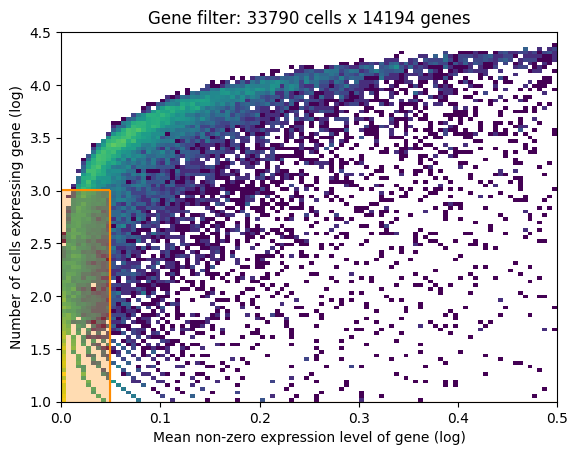

In [36]:
# filter the scRNAseq data 
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
adata_ref = adata_ref[:, selected].copy()

 Orange area is the genes excluded based on the combination of number of cells expressing that gene (Y-axis) and average RNA count for cells where the gene was detected (X-axis).

##  Estimation of reference cell type signatures (NB regression)

In [37]:
adata_ref

AnnData object with n_obs × n_vars = 33790 × 14194
    obs: 'Study_id', 'Celltype_subset', 'bc_subtype', 'donor_age', 'treatment_status', 'grade', 'IHC_subtype', 'Dataset', 'Celltype_major'
    var: 'ENSEMBL', 'mt', 'ribo', 'n_cells', 'nonz_mean'

### Train the model

In [38]:
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='Study_id',
                        # cell type, covariate used for constructing signatures
                        labels_key='Celltype_major'
                       )

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [39]:
# create model
mod = RegressionModel(adata_ref)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.6.post2.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Study_id',
│   'labels_key': 'Celltype_major',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  10   │
│         n_cells          │ 33790 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   9   │
│          n_vars          │ 14194 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Study_id'] │  CID3941   │          0          │
│                       │  CID3948   │          1          │
│                       │  CID4040   │          2          │
│                       │  CID4067   │          3          │
│                       │  CID4290A  │          4          │
│                       │  CID4461   │          5          │
│                       │  CID4463   │          6          │
│                       │  CID4471   │          7          │
│                       │  CID4530N  │          8          │
│                       │  CID4535   │          9          │
└───────────────────────┴────────────┴─────────────────────┘

                          labels State Registry                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location       ┃    Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Celltype_major'] │      B-cells      │          0          │
│                             │       CAFs        │          1          │
│                             │ Cancer Epithelial │          2          │
│                             │    Endothelial    │          3          │
│                             │      Myeloid      │          4          │
│                             │ Normal Epithelial │          5          │
│                             │        PVL        │          6          │
│                             │   Plasmablasts    │          7          │
│                             │      T-cells      │          8          │
└─────────────────────────────┴───────────────────┴─────────────────────┘

In [40]:
# train the model
mod.train(max_epochs=400, accelerator='gpu', device=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/disk2/user/hilpek/miniconda3/envs/cell2_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/disk2/user/hilpek/miniconda3/envs/cell2_env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [16:20<00:00,  3.12s/it, v_num=1, elbo_train=2.13e+8]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [16:20<00:00,  2.45s/it, v_num=1, elbo_train=2.13e+8]


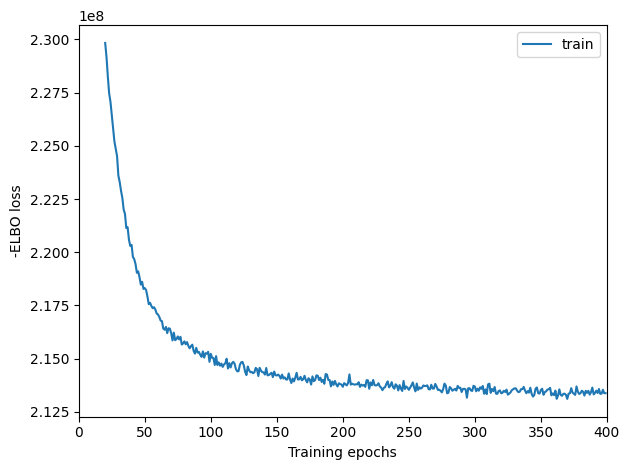

In [41]:
# plot ELBO loss history during training, removing first 20 epochs
mod.plot_history(20)

This plot should have a decreasing trend and level off by the end of training. If it is still decreasing, max_epochs needs to be increased. 

### Export results

In [42]:
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500}
)
# save model
mod.save(f"{ref_run_name}", overwrite=True)

# save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Sampling global variables, sample: 100%|██████████| 999/999 [00:27<00:00, 35.95it/s]


'/disk2/user/hilpek/project_root/cell2location/outputs/cell2loc2_1/reference_signatures/sc.h5ad'

### Examine QC

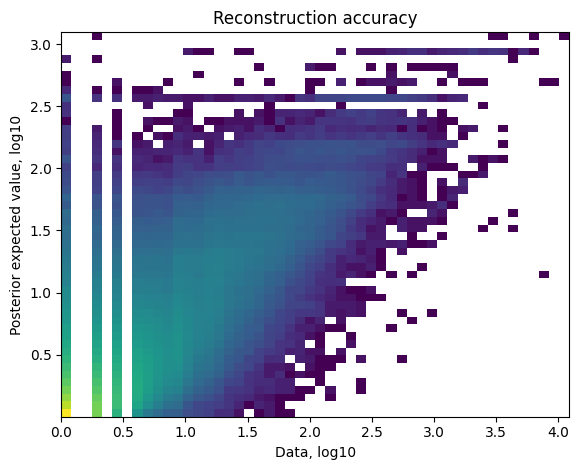

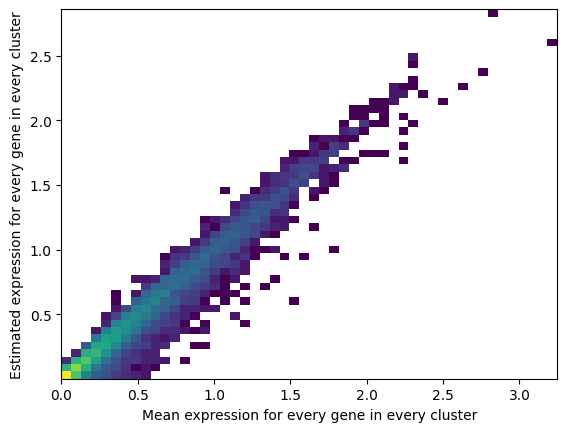

In [43]:
# QC examination
mod.plot_QC()

1.Reconstruction accuracy to assess if there are any issues with inference. This 2D histogram plot should have most observations along a noisy diagonal.


2.The estimated expression signatures are distinct from mean expression in each cluster because of batch effects. For scRNA-seq datasets which do not suffer from batch effect, cluster average expression can be used instead of estimating signatures with a model. When this plot is very different from a diagonal plot (e.g. very low values on Y-axis, density everywhere) it indicates problems with signature estimation.
 

## Extract reference cell type signatures to Pandas

Note: All parameters of the a Negative Binomial regression model are exported into reference anndata object, however for spatial mapping we just need the estimated expression of every gene in every cell type. Here we extract that from standard output:

In [44]:
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.head()

B-cells      CAFs  Cancer Epithelial  Endothelial   Myeloid  \
FO538757.2     0.024765  0.093593           0.217249     0.119248  0.096202   
AP006222.2     0.003784  0.065367           0.064866     0.049014  0.040962   
RP11-206L10.9  0.008072  0.017142           0.072033     0.013740  0.027499   
SAMD11         0.003004  0.151177           0.004863     0.005599  0.001291   
NOC2L          0.043286  0.129535           0.615619     0.194454  0.125705   

               Normal Epithelial       PVL  Plasmablasts   T-cells  
FO538757.2              0.202103  0.071638      0.024366  0.017824  
AP006222.2              0.052650  0.056735      0.003890  0.000921  
RP11-206L10.9           0.044395  0.036549      0.015357  0.004170  
SAMD11                  0.004483  0.002992      0.011090  0.000225  
NOC2L                   0.528023  0.105826      0.055493  0.035784

In [45]:
import mygene
mg = mygene.MyGeneInfo()

# Get Ensembl IDs
ensembl_ids = adata_vis.var_names.tolist()

# Query gene symbols using mygene
query = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='human')

# Create a mapping from Ensembl ID to gene symbol (filter out entries with no symbol)
ens_to_symbol = {q['query']: q['symbol'] for q in query if 'symbol' in q and q['symbol'] is not None}

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


90 input query terms found no hit:	['ENSG00000271895', 'ENSG00000261135', 'ENSG00000225986', 'ENSG00000273373', 'ENSG00000259834', 'ENS


In [46]:
# Keep only genes that have a matching symbol
valid_genes = [g for g in adata_vis.var_names if g in ens_to_symbol]

# Filter and rename the gene names in the object
adata_vis = adata_vis[:, valid_genes].copy()
adata_vis.var_names = [ens_to_symbol[g] for g in valid_genes]

In [47]:
print("adata_vis.shape (final):", adata_vis.shape)
print("inf_aver.shape (final):", inf_aver.shape)
print("Example gene names:", adata_vis.var_names[:5])

adata_vis.shape (final): (1762, 13722)
inf_aver.shape (final): (14194, 9)
Example gene names: Index(['LINC01409', 'LINC01128', 'LINC02593', 'SAMD11', 'NOC2L'], dtype='object')


##  Cell2location: spatial mapping

In [48]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)

adata_vis.var_names_make_unique()


print(f"Common gene count: {len(intersect)}")


adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

Common gene count: 11067


### Train the model

**Important:** To use cell2location spatial mapping model, you need to specify 2 user-provided hyperparameters (N_cells_per_location and detection_alpha).

_a) Choosing hyperparameter ``N_cells_per_location``_

It is useful to adapt the expected cell abundance N_cells_per_location to every tissue. This value can be estimated from paired histology images as explained [here](https://github.com/BayraktarLab/cell2location/blob/master/docs/images/Note_on_selecting_hyperparameters.pdf). This parameter can be estimated by manually counting nuclei in a 10-20 locations in the histology image (e.g. using 10X Loupe browser), and computing the average cell abundance.

_b) Choosing hyperparameter ``detection_alpha``_

To improve accuracy & sensitivity on datasets with large technical variability in RNA detection sensitivity within the slide/batch - you need to relax regularisation of per-location normalisation (use detection_alpha=20). High technical variability in RNA detection sensitivity is present in your sample when you observe the spatial distribution of total RNA count per location that doesn’t match expected cell numbers based on histological examination.

In [49]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=40,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=5
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.6.post2.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 1762  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 11067 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃  Categories  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ V10F03-034_C │          0          │
└─────────────────────┴──────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [50]:
mod.train(max_epochs=40000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          log_every_n_steps=1,
         )

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/disk2/user/hilpek/miniconda3/envs/cell2_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/disk2/user/hilpek/miniconda3/envs/cell2_env/lib/python3.9/site-pac

Epoch 40000/40000: 100%|██████████| 40000/40000 [2:24:18<00:00,  4.63it/s, v_num=1, elbo_train=3.86e+6]  

`Trainer.fit` stopped: `max_epochs=40000` reached.


Epoch 40000/40000: 100%|██████████| 40000/40000 [2:24:18<00:00,  4.62it/s, v_num=1, elbo_train=3.86e+6]


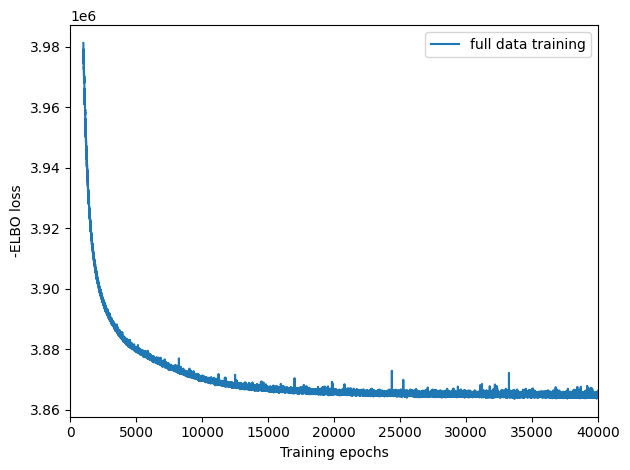

In [51]:
# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

### Export results

In [52]:
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Sampling global variables, sample: 100%|██████████| 999/999 [00:45<00:00, 21.96it/s]


### Examine QC

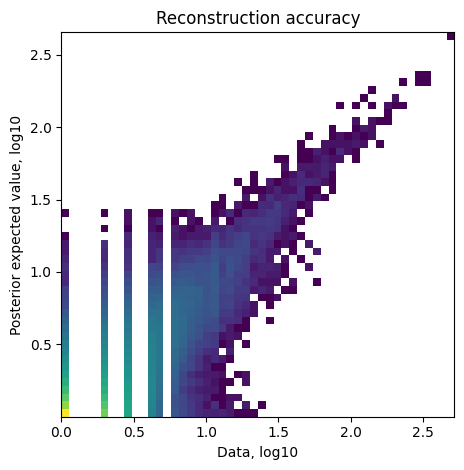

In [53]:
mod.plot_QC()

In [54]:
adata_vis

AnnData object with n_obs × n_vars = 1762 × 11067
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'Pathologist_annotations', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'mt_frac', 'ribo_frac', 'n_genes', 'n_counts', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'genome', 'SYMBOL', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'spatial', 'Pathologist_annotations_colors', '_scvi_uuid', '_scvi_manager_uuid', 'mod'
    obsm: 'spatial', 'MT', 'RB', 'means_cell_abundance_w_sf', 'stds_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf'

###  Visualising cell abundance in spatial coordinates

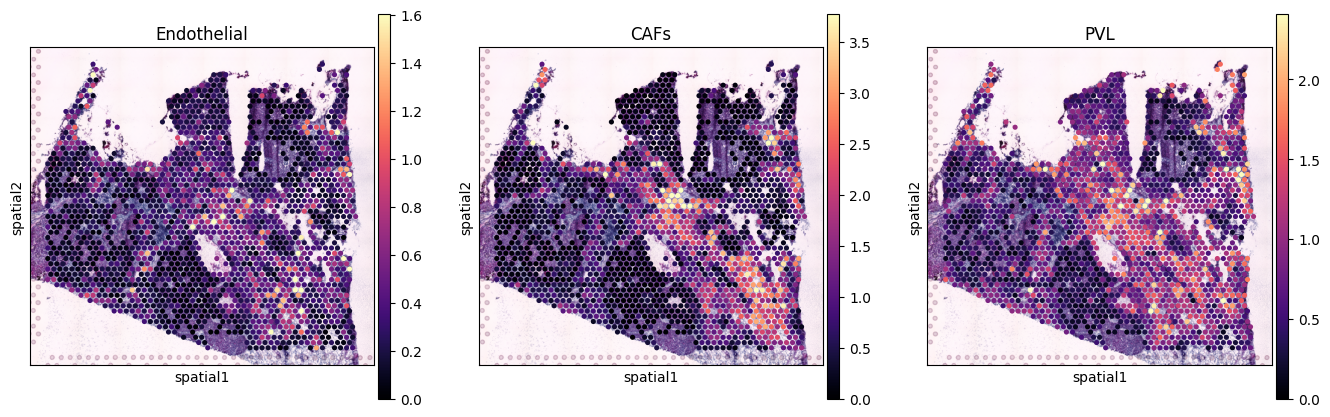

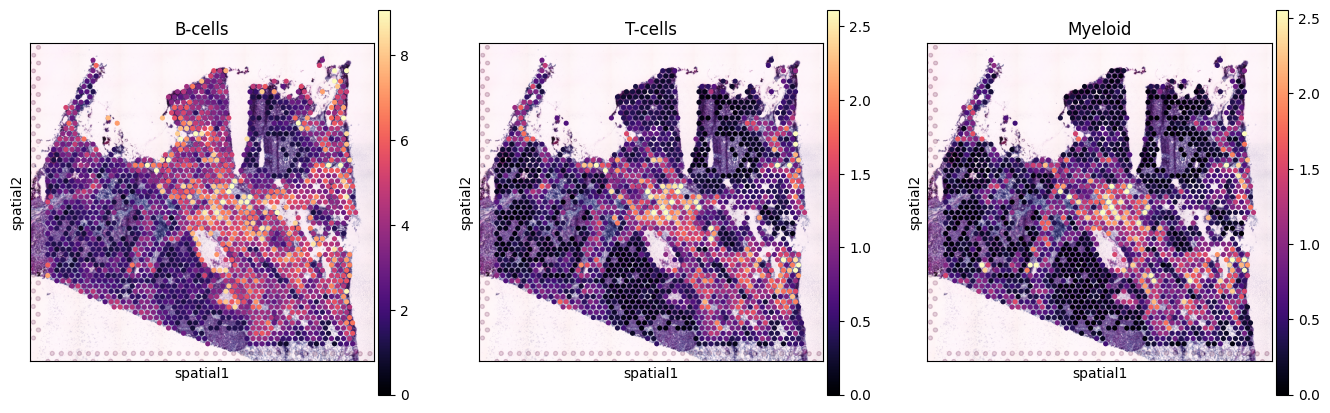

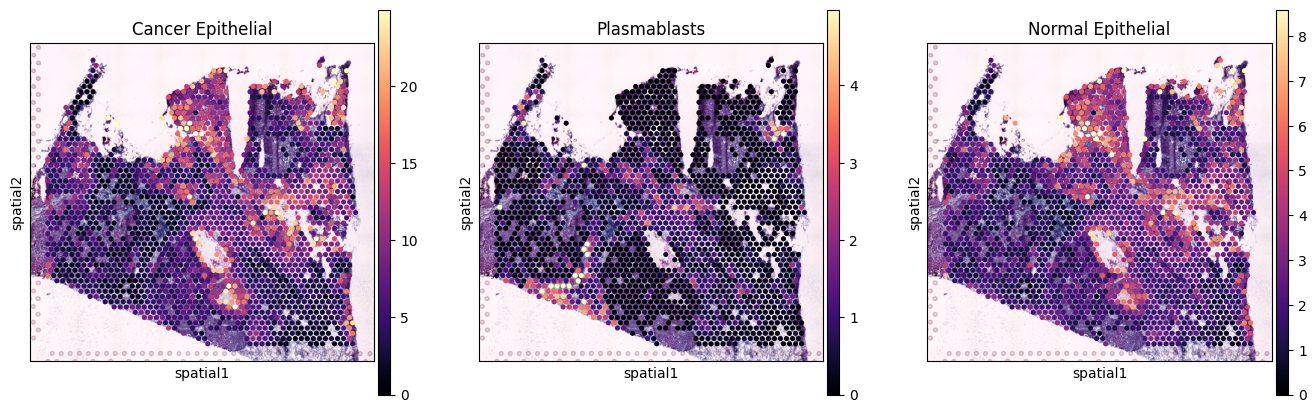

In [55]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# visualise all cell types
slide = select_slide(adata_vis, 'V10F03-034_C')

cell_types = list(adata_ref.obs["Celltype_major"].unique())
for i in range(0, len(cell_types), 3):
    with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
        sc.pl.spatial(slide, cmap='magma',
                      # show first 8 cell types
                      color=cell_types[i:i+3],
                      ncols=4, size=1.3,
                      img_key='hires',
                      # limit color scale at 99.2% quantile of cell abundance
                      vmin=0, vmax='p99.2'
                     )

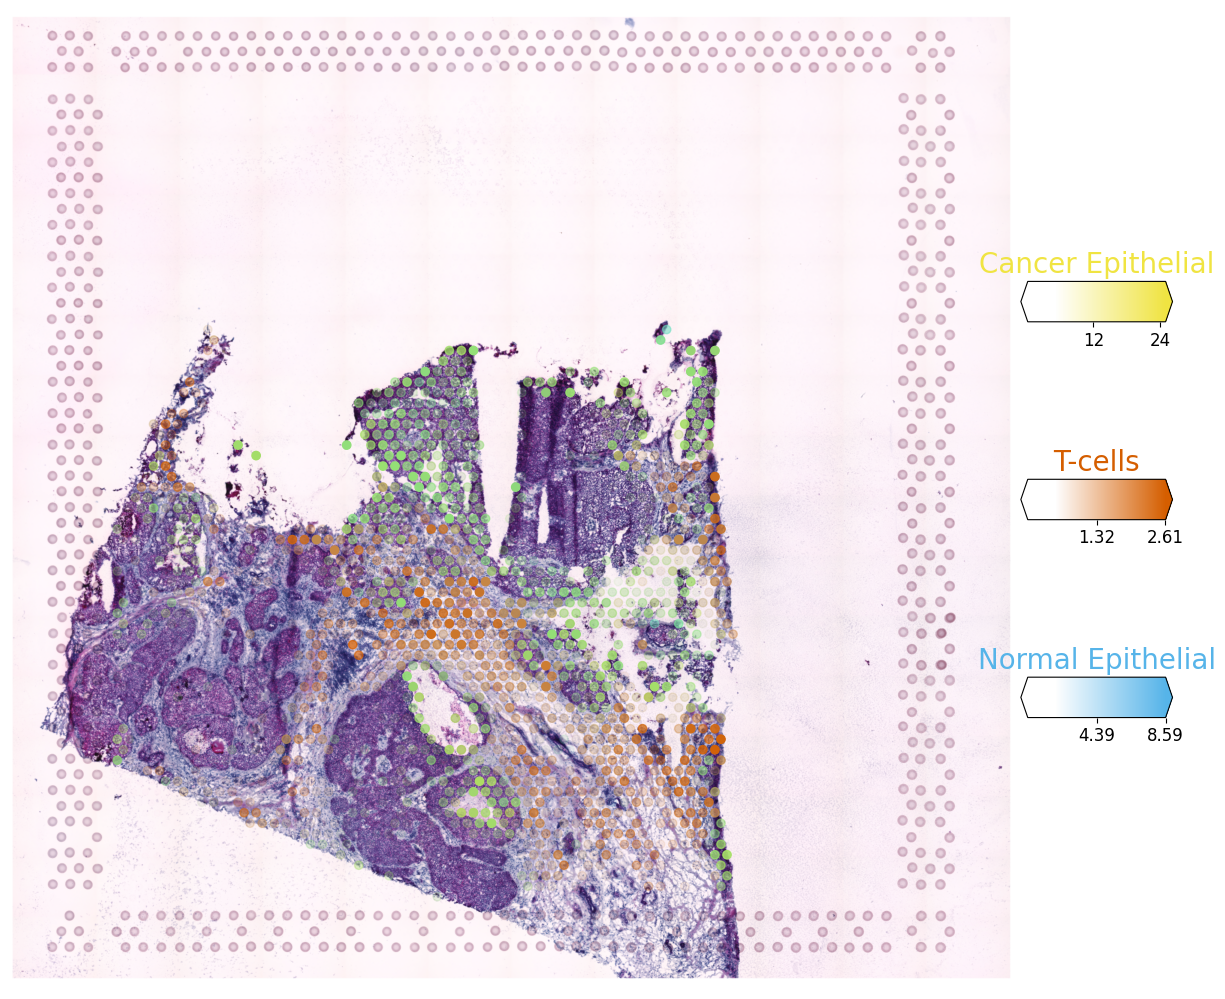

In [56]:
# use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters
clust_labels = ['Cancer Epithelial', 'T-cells', 'Normal Epithelial']
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

slide = select_slide(adata_vis, 'V10F03-034_C')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6,
        colorbar_position='right'
    )

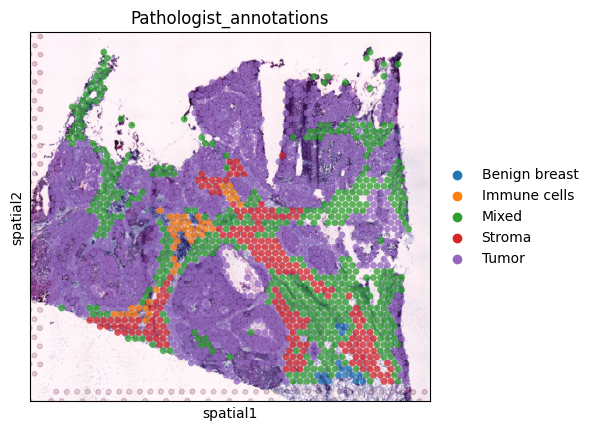

In [57]:
# pathologist annotation of the used sample
sc.pl.spatial(adata_vis, img_key="hires", color="Pathologist_annotations", size=1.5, alpha=0.75)

###  Save the results of the estimation for each slide separately

In [58]:
slides = ["V10F03-034_C"]
for slide_name in slides:
    adata_slide = select_slide(adata_vis, 'V10F03-034_C')
    adata_slide.write(os.path.join(results_folder +"/estimations", slide_name + ".h5ad"))

###  Re-annotation based on the cell2location mappings

In [59]:
# run this cell to load a slide without running the above analysis
slide_name = "V10F03-034_C"
slide = sc.read(os.path.join(results_folder +"/estimations", slide_name))
slide

AnnData object with n_obs × n_vars = 1762 × 11067
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'Pathologist_annotations', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'mt_frac', 'ribo_frac', 'n_genes', 'n_counts', '_indices', '_scvi_batch', '_scvi_labels', 'B-cells', 'CAFs', 'Cancer Epithelial', 'Endothelial', 'Myeloid', 'Normal Epithelial', 'PVL', 'Plasmablasts', 'T-cells'
    var: 'feature_types', 'genome', 'SYMBOL', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'Pathologist_annotations_colors', '_scvi_manager_uuid', '_scvi_uuid', 'mod', 'spatial'
    obsm: 'MT', 'RB', 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'

In [60]:
slide = select_slide(adata_vis, 'V10F03-034_C')
slide

AnnData object with n_obs × n_vars = 1762 × 11067
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'Pathologist_annotations', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'mt_frac', 'ribo_frac', 'n_genes', 'n_counts', '_indices', '_scvi_batch', '_scvi_labels', 'B-cells', 'CAFs', 'Cancer Epithelial', 'Endothelial', 'Myeloid', 'Normal Epithelial', 'PVL', 'Plasmablasts', 'T-cells'
    var: 'feature_types', 'genome', 'SYMBOL', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'spatial', 'Pathologist_annotations_colors', '_scvi_uuid', '_scvi_manager_uuid', 'mod'
    obsm: 'spatial', 'MT', 'RB', 'means_cell_abundance_w_sf', 'stds_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf'

The idea behind this re-assignment approach is that for each cell type, the spots with estimated cell abundance values above the range of the threshold are assigned as that cell type. For example, if minimum estimation for Plasmablasts is 0 and maximum estimation is 10 with a 0.7 (== 70%) threshold, then the spots which have an estimation above 7 will be re-assigned as Plasmablasts.

In [61]:
for cell_type in adata_ref.obs["Celltype_major"].unique():
    # get the mapping results for the cell_type
    mapping = slide.obs[cell_type]

    # get the range of the cell abundance estimations
    est_min = min(mapping)
    est_max = max(mapping)
    est_range = est_max - est_min

    # determine the threshold for cell type assignment to spots (between 0 and 1)
    threshold = 0.7

    # create a column for cell_type assignment
    slide.obs["Assign " + cell_type + "?"] = mapping >= (est_min + est_range * threshold)

### Determine the number of assignments for each spot

In [62]:
assign_columns = [col for col in slide.obs.columns if col.startswith("Assign ")]

# count the number of True values in assignments
slide.obs["Assignment Count"] = slide.obs[assign_columns].sum(axis=1)
slide.obs

in_tissue  array_row  array_col  \
spot_id                                                            
V10F03-034_C_AAACACCAATAACTGC-1          1         59         19   
V10F03-034_C_AAACAGCTTTCAGAAG-1          1         43          9   
V10F03-034_C_AAACAGGGTCTATATT-1          1         47         13   
V10F03-034_C_AAACAGTGTTCCTGGG-1          1         73         43   
V10F03-034_C_AAACATGGTGAGAGGA-1          1         62          0   
...                                    ...        ...        ...   
V10F03-034_C_TTGTGTTTCCCGAAAG-1          1         51         59   
V10F03-034_C_TTGTTGTGTGTCAAGA-1          1         31         77   
V10F03-034_C_TTGTTTCATTAGTCTA-1          1         60         30   
V10F03-034_C_TTGTTTCCATACAACT-1          1         45         27   
V10F03-034_C_TTGTTTGTATTACACG-1          1         73         41   

                                       sample Pathologist_annotations  \
spot_id                                                                 
V10F03-034_C_AAACACCAATAACTGC-1  V10F03-034_C                   Tumor   
V10F03-034_C_AAACAGCTTTCAGAAG-1  V10F03-034_C                   Tumor   
V10F03-034_C_AAACAGGGTCTATATT-1  V10F03-034_C                   Mixed   
V10F03-034_C_AAACAGTGTTCCTGGG-1  V10F03-034_C                   Tumor   
V10F03-034_C_AAACATGGTGAGAGGA-1  V10F03-034_C                   Tumor   
...                                       ...                     ...   
V10F03-034_C_TTGTGTTTCCCGAAAG-1  V10F03-034_C                  Stroma   
V10F03-034_C_TTGTTGTGTGTCAAGA-1  V10F03-034_C                   Tumor   
V10F03-034_C_TTGTTTCATTAGTCTA-1  V10F03-034_C                   Mixed   
V10F03-034_C_TTGTTTCCATACAACT-1  V10F03-034_C                   Tumor   
V10F03-034_C_TTGTTTGTATTACACG-1  V10F03-034_C                   Tumor   

                                 n_genes_by_counts  total_counts  \
spot_id                                                            
V10F03-034_C_AAACACCAATAACTGC-1                447         562.0   
V10F03-034_C_AAACAGCTTTCAGAAG-1                711         980.0   
V10F03-034_C_AAACAGGGTCTATATT-1                754         939.0   
V10F03-034_C_AAACAGTGTTCCTGGG-1                306         352.0   
V10F03-034_C_AAACATGGTGAGAGGA-1               1229        1770.0   
...                                            ...           ...   
V10F03-034_C_TTGTGTTTCCCGAAAG-1                721        1269.0   
V10F03-034_C_TTGTTGTGTGTCAAGA-1                338         383.0   
V10F03-034_C_TTGTTTCATTAGTCTA-1               1208        2311.0   
V10F03-034_C_TTGTTTCCATACAACT-1                294         372.0   
V10F03-034_C_TTGTTTGTATTACACG-1                402         489.0   

                                 total_counts_mt  pct_counts_mt  \
spot_id                                                           
V10F03-034_C_AAACACCAATAACTGC-1             11.0       1.957295   
V10F03-034_C_AAACAGCTTTCAGAAG-1             22.0       2.244898   
V10F03-034_C_AAACAGGGTCTATATT-1             18.0       1.916933   
V10F03-034_C_AAACAGTGTTCCTGGG-1             17.0       4.829545   
V10F03-034_C_AAACATGGTGAGAGGA-1             19.0       1.073446   
...                                          ...            ...   
V10F03-034_C_TTGTGTTTCCCGAAAG-1             35.0       2.758077   
V10F03-034_C_TTGTTGTGTGTCAAGA-1             12.0       3.133159   
V10F03-034_C_TTGTTTCATTAGTCTA-1             34.0       1.471225   
V10F03-034_C_TTGTTTCCATACAACT-1             12.0       3.225806   
V10F03-034_C_TTGTTTGTATTACACG-1             20.0       4.089980   

                                 total_counts_ribo  ...  Assign Endothelial?  \
spot_id                                             ...                        
V10F03-034_C_AAACACCAATAACTGC-1               56.0  ...                False   
V10F03-034_C_AAACAGCTTTCAGAAG-1              140.0  ...                False   
V10F03-034_C_AAACAGGGTCTATATT-1               92.0  ...                False   
V10F03-034_C_AAACAGTGTTCCTGGG-1          

In [63]:
slide.obs[slide.obs["Assignment Count"]==0]

in_tissue  array_row  array_col  \
spot_id                                                            
V10F03-034_C_AAACACCAATAACTGC-1          1         59         19   
V10F03-034_C_AAACAGCTTTCAGAAG-1          1         43          9   
V10F03-034_C_AAACAGGGTCTATATT-1          1         47         13   
V10F03-034_C_AAACAGTGTTCCTGGG-1          1         73         43   
V10F03-034_C_AAACATGGTGAGAGGA-1          1         62          0   
...                                    ...        ...        ...   
V10F03-034_C_TTGTGTTTCCCGAAAG-1          1         51         59   
V10F03-034_C_TTGTTGTGTGTCAAGA-1          1         31         77   
V10F03-034_C_TTGTTTCATTAGTCTA-1          1         60         30   
V10F03-034_C_TTGTTTCCATACAACT-1          1         45         27   
V10F03-034_C_TTGTTTGTATTACACG-1          1         73         41   

                                       sample Pathologist_annotations  \
spot_id                                                                 
V10F03-034_C_AAACACCAATAACTGC-1  V10F03-034_C                   Tumor   
V10F03-034_C_AAACAGCTTTCAGAAG-1  V10F03-034_C                   Tumor   
V10F03-034_C_AAACAGGGTCTATATT-1  V10F03-034_C                   Mixed   
V10F03-034_C_AAACAGTGTTCCTGGG-1  V10F03-034_C                   Tumor   
V10F03-034_C_AAACATGGTGAGAGGA-1  V10F03-034_C                   Tumor   
...                                       ...                     ...   
V10F03-034_C_TTGTGTTTCCCGAAAG-1  V10F03-034_C                  Stroma   
V10F03-034_C_TTGTTGTGTGTCAAGA-1  V10F03-034_C                   Tumor   
V10F03-034_C_TTGTTTCATTAGTCTA-1  V10F03-034_C                   Mixed   
V10F03-034_C_TTGTTTCCATACAACT-1  V10F03-034_C                   Tumor   
V10F03-034_C_TTGTTTGTATTACACG-1  V10F03-034_C                   Tumor   

                                 n_genes_by_counts  total_counts  \
spot_id                                                            
V10F03-034_C_AAACACCAATAACTGC-1                447         562.0   
V10F03-034_C_AAACAGCTTTCAGAAG-1                711         980.0   
V10F03-034_C_AAACAGGGTCTATATT-1                754         939.0   
V10F03-034_C_AAACAGTGTTCCTGGG-1                306         352.0   
V10F03-034_C_AAACATGGTGAGAGGA-1               1229        1770.0   
...                                            ...           ...   
V10F03-034_C_TTGTGTTTCCCGAAAG-1                721        1269.0   
V10F03-034_C_TTGTTGTGTGTCAAGA-1                338         383.0   
V10F03-034_C_TTGTTTCATTAGTCTA-1               1208        2311.0   
V10F03-034_C_TTGTTTCCATACAACT-1                294         372.0   
V10F03-034_C_TTGTTTGTATTACACG-1                402         489.0   

                                 total_counts_mt  pct_counts_mt  \
spot_id                                                           
V10F03-034_C_AAACACCAATAACTGC-1             11.0       1.957295   
V10F03-034_C_AAACAGCTTTCAGAAG-1             22.0       2.244898   
V10F03-034_C_AAACAGGGTCTATATT-1             18.0       1.916933   
V10F03-034_C_AAACAGTGTTCCTGGG-1             17.0       4.829545   
V10F03-034_C_AAACATGGTGAGAGGA-1             19.0       1.073446   
...                                          ...            ...   
V10F03-034_C_TTGTGTTTCCCGAAAG-1             35.0       2.758077   
V10F03-034_C_TTGTTGTGTGTCAAGA-1             12.0       3.133159   
V10F03-034_C_TTGTTTCATTAGTCTA-1             34.0       1.471225   
V10F03-034_C_TTGTTTCCATACAACT-1             12.0       3.225806   
V10F03-034_C_TTGTTTGTATTACACG-1             20.0       4.089980   

                                 total_counts_ribo  ...  Assign Endothelial?  \
spot_id                                             ...                        
V10F03-034_C_AAACACCAATAACTGC-1               56.0  ...                False   
V10F03-034_C_AAACAGCTTTCAGAAG-1              140.0  ...                False   
V10F03-034_C_AAACAGGGTCTATATT-1               92.0  ...                False   
V10F03-034_C_AAACAGTGTTCCTGGG-1          

In [64]:
countlist = list(slide.obs["Assignment Count"].unique())
countlist.sort()
for num in countlist:
    print("num of cell types assigned:", num, "num of spots assigned:", slide.obs[slide.obs["Assignment Count"]==num].shape[0])

num of cell types assigned: 0 num of spots assigned: 1624
num of cell types assigned: 1 num of spots assigned: 77
num of cell types assigned: 2 num of spots assigned: 36
num of cell types assigned: 3 num of spots assigned: 20
num of cell types assigned: 4 num of spots assigned: 3
num of cell types assigned: 5 num of spots assigned: 2


## Identifying discrete tissue regions by Leiden clustering

In [65]:
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(adata_vis, use_rep='q05_cell_abundance_w_sf',
                n_neighbors = 15)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=1.1)

# add region as categorical variable
adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"].astype("category")

/tmp/ipykernel_310939/23575634.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_vis, resolution=1.1)


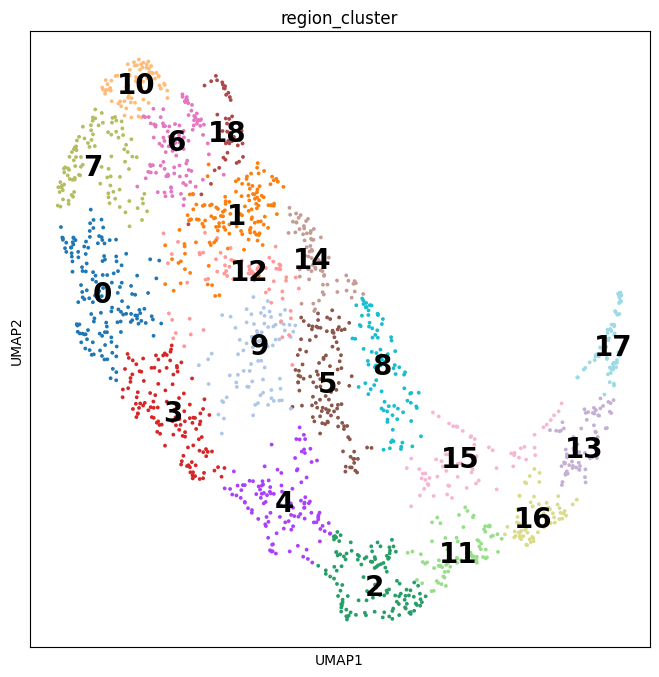

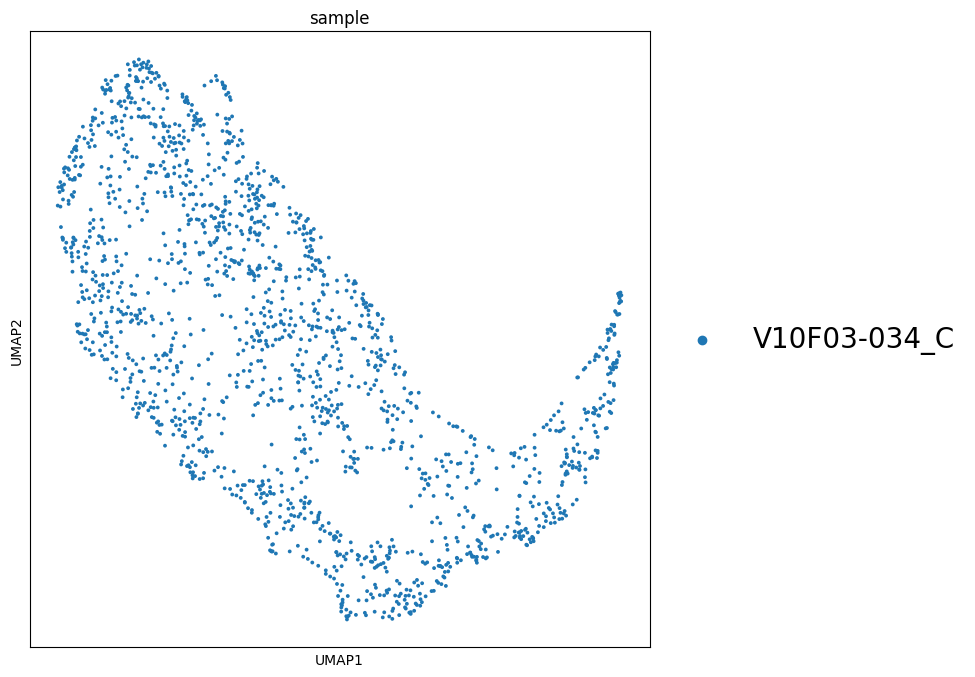

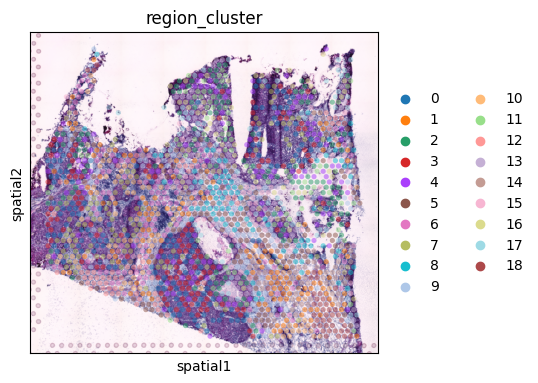

In [66]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [8, 8]}):
    sc.pl.umap(adata_vis, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20)
    sc.pl.umap(adata_vis, color=['sample'], size=30,
               color_map = 'RdPu', ncols = 2,
               legend_fontsize=20)

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(adata_vis, color=['region_cluster'],
                  size=1.3, img_key='hires', alpha=0.5)

### Identifying cellular compartments / tissue zones using matrix factorisation (NMF)

In [67]:
from cell2location import run_colocation
res_dict, adata_vis = run_colocation(
    adata_vis,
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': np.arange(11, 13), # IMPORTANT: use a wider range of the number of factors (5-30)
      'sample_name_col': 'sample', # columns in adata_vis.obs that identifies sample
      'n_restarts': 3 # number of training restarts
    },
    # the hyperparameters of NMF can be also adjusted:
    model_kwargs={'alpha': 0.01, 'init': 'random', "nmf_kwd_args": {"tol": 0.000001}},
    export_args={'path': f'{run_name}/CoLocatedComb/'}
)

### Analysis name: CoLocatedGroupsSklearnNMF_11combinations_1762locations_9factors


/disk2/user/hilpek/miniconda3/envs/cell2_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/disk2/user/hilpek/miniconda3/envs/cell2_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


### Analysis name: CoLocatedGroupsSklearnNMF_12combinations_1762locations_9factors


/disk2/user/hilpek/miniconda3/envs/cell2_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/disk2/user/hilpek/miniconda3/envs/cell2_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/disk2/user/hilpek/miniconda3/envs/cell2_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/disk2/user/hilpek/miniconda3/envs/cell2_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


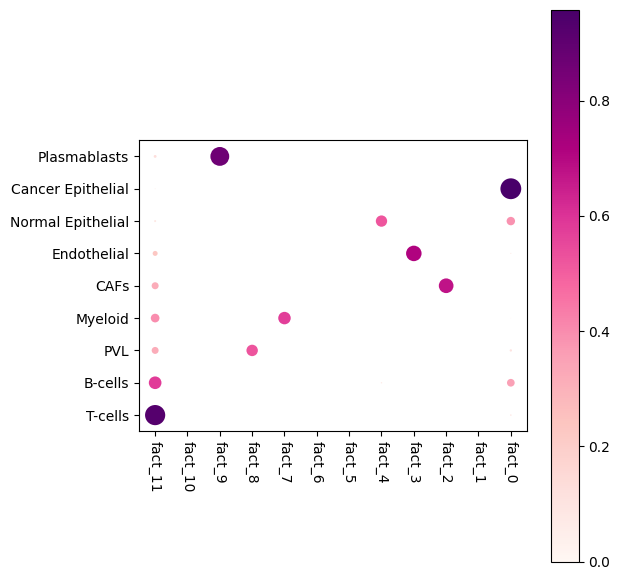

In [68]:
# Here we plot the NMF weights (Same as saved to `cell_type_fractions_heatmap`)
res_dict['n_fact12']['mod'].plot_cell_type_loadings()

###  Save the assignment results

In [69]:
slide_name = "V10F03-034_C"
slide.write(os.path.join(results_folder +"/estimations", slide_name + ".h5ad"))